## Minimal notebook attempting to reproduce the result of Theorem 3.2 from [Arora et al. (2019)](https://arxiv.org/abs/1904.11955)

In this notebook, we check **Theorem 3.2** from [Arora et al. (2019)](https://arxiv.org/abs/1904.11955) by training several neural networks (with different random seeds) under the **NTK scaling**, and comparing their predictions to those of a **kernel ridgeless predictor** computed using the *theoretical*, rather than *empirical* NTK.


In [ ]:
import math
import random  # PRNG for seeding
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from plot_utils import plot_ntk_vs_net_by_angle
from tqdm import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # use GPU if available
torch.set_default_dtype(torch.float64)  # float64 for numerical stability

In [2]:
# Main functions of the notebook to train the networks, generate the data, get the NTK predictor etc...

def set_seed(s: int):
    """Set the random seed for all experiments."""
    random.seed(s)
    np.random.seed(s)  # NumPy RNG
    torch.manual_seed(s)  # PyTorch RNG


class ReLU1FC(nn.Module):
    """Single hidden layer network with ReLU activation (no bias)."""
    def __init__(self, dim_in: int, width: int, out_dim: int = 1, kappa = 1.0):
        super().__init__()

        self.in_dim = dim_in # input dimension
        self.width  = width # number of hidden units
        self.kappa  = kappa # scaling proposed by Arora, we keep it to one

        self.fc1 = nn.Linear(dim_in, width, bias=False)
        self.fc2 = nn.Linear(width, out_dim, bias=False)

        # initializing with N(0,1) gaussians
        with torch.no_grad():
            nn.init.normal_(self.fc1.weight, std=1.0)
            nn.init.normal_(self.fc2.weight, std=1.0)
    # forward with ntk scaling for relu net as in Equation (6) of Arora et al. (2019)
    def forward(self, x):
        h = self.fc1(x)
        h = math.sqrt(2) * torch.relu(h) / math.sqrt(self.width)

        # scaling by kappa as in Theorem 3.2 of Arora et al. (2019)
        return self.fc2(h) * self.kappa


# we are working in the setting of Arora et al. (2019) so data needs to be in the unit ball
def sample_on_unit_sphere(dim: int, n_samples: int, device=device, dtype=torch.get_default_dtype()):
    """ Sampling n points uniformly on the unit sphere S^{d-1} """
    # sample Gaussian
    x = torch.randn(n_samples, dim, device=device, dtype=dtype)  
    # normalize to sphere
    x = x / x.norm(dim=1, keepdim=True).clamp_min(1e-12)  
    return x


def grid_on_unit_sphere(n_points: int, dtype=None, centered: bool = True):
    """ uniform grid on the unit sphere S^{1}"""
    if dtype is None:
        dtype = torch.get_default_dtype()

    if n_points < 1:
        raise ValueError("n must be >= 1")

    # angles index for uniform grid
    k = torch.arange(n_points, device=device, dtype=dtype)
    if centered:
        # avoids landing exactly on R^d basis axes
        theta = 2.0 * math.pi * (k + 0.5) / n_points
    else:
        # uncentered grid
        theta = 2.0 * math.pi * k / n_points

    # get the coordinates on the sphere
    x_coords = torch.cos(theta)
    y_coords = torch.sin(theta)
    xy_coords = torch.stack([x_coords, y_coords], dim=1)  # shape (n_points, 2)

    return xy_coords.to(device=device, dtype=dtype)

# This is the labeling function for the training data. If you want to change the groundtruth, this is the function! 
def ground_truth(input_data: torch.Tensor):
    """ set the labels on the training data with no noise """
    x1, x2 = input_data[:,0], input_data[:,1]
    return (torch.cos(5*x1) + torch.sin(5*x2)).unsqueeze(1)

def train_model(model: nn.Module, input_data: torch.Tensor, labels: torch.Tensor, steps: int=2000, lr: float=0.01, verbose=False, K = None):  # train finite network
    """ Full-batch squared-loss training """
    model = model.to(input_data.device).to(input_data.dtype)
    # We use the SGD optimizer, but since the entire dataset is used in each update (no minibatches), 
    # this effectively performs full-batch gradient descent.
    opt = torch.optim.SGD(model.parameters(), lr=lr)  
    mse = nn.MSELoss()  
    for t in range(steps):
        # clear grad buffers
        opt.zero_grad(set_to_none=True)  
        labels_hat = model(input_data)
        loss = mse(labels_hat, labels)
        loss.backward()
        opt.step()
        if verbose and (t % max(1, steps//5) == 0 or t == steps-1):
            print(f"t={t:4d}  loss={loss.item():.6f}")
    return model


def rmse(a, b):
    """ root-mean-squared error helper """
    return math.sqrt(torch.mean((a-b)**2).item())

def _closed_form_ntk_relu_2layer(X1_data: torch.Tensor,
                                 X2_data: torch.Tensor | None = None,
                                 kappa: float = 1.0) -> torch.Tensor:
    """ closed-form NTK for 1-hidden layer ReLU at infinite width as in Equation (9) of Arora et al. (2019) applied with L = 1"""
    if X2_data is None:
        X2_data = X1_data

    X1_data = X1_data.to(torch.float64)  # ensure high-precision kernel math
    X2_data = X2_data.to(torch.float64)

    # Pairwise dot products
    dot_prod = X1_data @ X2_data.T

    # All the symbols here comes from Arora et al. (2019) Equation (9) and Appendix E.1
    # we clamp for numerical security, the dot product should be already between -1 and 1 as the data is normalized.
    rho   = (dot_prod).clamp(-1,1)
    arcsin_rho = torch.asin(rho)

    # ntk formula component from Equation (9) of Arora et al. (2019)
    # Sigma0 := \Sigma^{(0)}, Sigma1 := \Sigma^{(1)} and dot_Sigma1 := \dot\Sigma^{(1)} in Arora's notation.
    Sigma0   = rho
    # Sigma0**2 \in [0,1] but because of numerical problems he can be negative. So we clamp to protect against tiny negatives
    protected_sqrt = torch.clamp(1 - Sigma0**2, min=0)  
    Sigma1   = Sigma0/2 + (torch.sqrt(protected_sqrt) + Sigma0 * arcsin_rho)/torch.pi
    dot_Sigma1  = 1/2 + arcsin_rho/torch.pi

    # Closed-form NTK for one-hidden layer net
    K = (kappa ** 2) * ( Sigma0 * dot_Sigma1 + Sigma1)
    return K


def closed_form_ntk(kappa: float, X_data: torch.Tensor) -> torch.Tensor:
    """ theoritical NTK Gram matrix K(X, X) """
    return _closed_form_ntk_relu_2layer(X_data, None, kappa)


def closed_form_ntk_cross(kappa: float, X1_data: torch.Tensor, X2_data: torch.Tensor) -> torch.Tensor:
    """ theoritical cross NTK K(X1, X2) """
    return _closed_form_ntk_relu_2layer(X1_data, X2_data, kappa)

In [3]:
# In the cellula, we train the networks and record all necessary value such as network predictions for plotting.

################################################################################################################
# seed for data generation
set_seed(8)

# Config for the runs
# we have seeds as the statement of Theorem 3.2 in Arora et al. is made in high probability
SEEDS  = list(range(10))  # random seeds to average over 
WIDTHS = [10, 100, 1_000]  # hidden widths to sweep
N_TRAIN = 5  # number of training points
N_GRID  = 1_000  # number of points in the grid of S^1
# For now, we set it high to 'ensure' convergence by looking at the loss values.
STEPS   = 20_000  # number of Gradient Descent steps
DIM_DATA = 2  # input dimension


# get Grid
Xgrid = grid_on_unit_sphere(n_points = N_GRID).to(device)  # uniform angle grid (test)
# TRAIN FIXED
Xtr = sample_on_unit_sphere(dim = DIM_DATA, n_samples = N_TRAIN).to(device)  # random points on sphere (train)
ytr = ground_truth(Xtr).to(device)  # labels from target function

# dictionnary containers for metrics and predictions
l2_ode = {w: [] for w in WIDTHS}
l2_krr = {w: [] for w in WIDTHS}
linf_ode = {w: [] for w in WIDTHS}
linf_krr = {w: [] for w in WIDTHS}
drift_rel = {w: [] for w in WIDTHS}
y_ntk_grid_dict = {w: [] for w in WIDTHS}   # stores NTK KRR prediction on Xte
y_net_grid_dict = {w: [] for w in WIDTHS}   # stores trained net prediction on Xte

################################################################################################################
# Closed-form NTK (theoritical at infinite width)
kappa = 1.0
K_trtr = closed_form_ntk(kappa, Xtr)  # infinite-width NTK Gram (train×train)
K_tetr = closed_form_ntk_cross(kappa, Xgrid, Xtr)  # cross NTK (test×train)
# test if the K_trtr is ill-conditioned
torch.min(torch.linalg.eigvalsh(K_trtr)).item()

# computing the kernel ridgeless regressors
alpha_krr = torch.linalg.solve(K_trtr, ytr)  # KRR coefficients α = K^{-1}y
y_krr_grid = K_tetr @ alpha_krr  # NTK KRR prediction on test
################################################################################################################


# sweep over widths and train the different seeds networks
for width in tqdm(WIDTHS):
    # loop over random initializations
    for seed in tqdm(SEEDS):
        set_seed(seed)  # fix data generation

        # init the network
        net = ReLU1FC(dim_in = DIM_DATA, width = width, kappa = kappa).to(device)
        # no need of adaptative learning rate scheduler as we scale the output by 1/sqrt(width). lr = 0.1 is kinda arbitrary, we choosed it experimentaly
        # Train net 
        net_tr = train_model(net, Xtr, ytr, steps=STEPS, lr=0.1, verbose=True)  

        # get predictions
        with torch.no_grad():
            y_net_tr = net_tr(Xtr)
            y_net_grid = net_tr(Xgrid)


        # save the metrics
        l2_krr[width].append(rmse(y_net_grid, y_krr_grid))  # RMSE between prediction of net and KRR
        linf_krr[width].append(torch.max(torch.abs(y_net_grid - y_krr_grid)).item())  # uniform gap between prediction of net and KRR
        y_ntk_grid_dict[width].append(y_krr_grid.detach().cpu().squeeze(1))  # store NTK prediction on grid (per seed)
        y_net_grid_dict[width].append(y_net_grid.detach().cpu().squeeze(1))  # store network prediction on grid (per seed)



  0%|          | 0/3 [00:00<?, ?it/s]

t=   0  loss=2.528657
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=0.824956
t=4000  loss=0.000063
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=0.744999
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=6.120174
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=1.422657
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=1.277250
t=4000  loss=0.000383
t=8000  loss=0.000049
t=12000  loss=0.000007
t=16000  loss=0.000001


t=19999  loss=0.000000
t=   0  loss=0.973430
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=4.935582
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=1.503072
t=4000  loss=0.000018
t=8000  loss=0.000001
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.873963
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


 33%|███▎      | 1/3 [00:18<00:37, 18.92s/it]

t=19999  loss=0.000000


t=   0  loss=1.100848
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=0.946908
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.109999
t=4000  loss=0.000097
t=8000  loss=0.000005
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.376730
t=4000  loss=0.000013
t=8000  loss=0.000001
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=1.551126
t=4000  loss=0.000017
t=8000  loss=0.000001
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.666640
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.131566
t=4000  loss=0.000011
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=1.237108
t=4000  loss=0.000031
t=8000  loss=0.000001
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=3.886683
t=4000  loss=0.000004
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=1.678630
t=4000  loss=0.000053
t=8000  loss=0.000004
t=12000  loss=0.000000
t=16000  loss=0.000000


 67%|██████▋   | 2/3 [00:37<00:18, 18.63s/it]

t=19999  loss=0.000000


t=   0  loss=5.043071
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.566635
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=4.441431
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=1.967420
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=4.409327
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.043367
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.943250
t=4000  loss=0.000005
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=3.742683
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=0.998366
t=4000  loss=0.000000
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


t=19999  loss=0.000000
t=   0  loss=2.727708
t=4000  loss=0.000004
t=8000  loss=0.000000
t=12000  loss=0.000000
t=16000  loss=0.000000


100%|██████████| 3/3 [01:04<00:00, 21.48s/it]

t=19999  loss=0.000000


In [4]:
# Cellula to preprocess the recorded metrics
def agg(d):
    """ small helper to mean/std aggregate across seeds """
    xs = list(d.keys())
    mus = [float(np.mean(d[w])) for w in xs]
    sig = [float(np.std(d[w], ddof=1)) if len(d[w])>1 else 0.0 for w in xs]
    return xs, mus, sig

# aggregate the computed metrics
_,  l2_krr_m,  l2_krr_s  = agg(l2_krr)
xs,  linf_krr_m, linf_krr_s = agg(linf_krr)

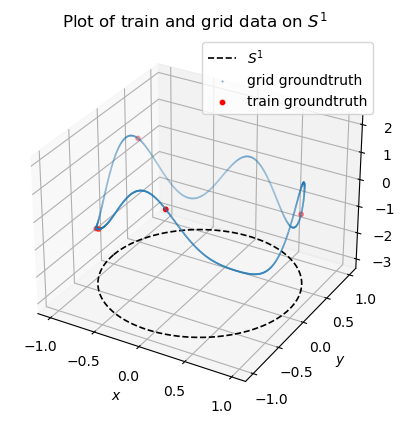

In [5]:
# Visualizing the train data in red and in blue the grid

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# train data
x_train = Xtr[:, 0].cpu().numpy()
y_train = Xtr[:, 1].cpu().numpy()
z_train = ytr.cpu().numpy().flatten()

# grid data
x_grid = Xgrid[:, 0].cpu().numpy()
y_grid = Xgrid[:, 1].cpu().numpy()
yte = ground_truth(Xgrid)
z_grid = yte.cpu().numpy().flatten()

# draw S^1 grid in black
x_s1 = Xgrid[:, 0].cpu().numpy()
y_s1 = Xgrid[:, 1].cpu().numpy()
# sort by angle so the line doesn’t zigzag
angles = np.arctan2(y_s1, x_s1)
order = np.argsort(angles)
z_base = np.full_like(order, fill_value=z_train.min() - 3)  # push circle slightly below labels
ax.plot(x_s1[order], y_s1[order], z_base, color="k", linewidth=1.2, linestyle='dashed', label='$S^1$')

# plot the grid groundtruth and train labels.
ax.scatter(x_grid , y_grid , z_grid, s = 0.1, label='grid groundtruth')
ax.scatter(x_train, y_train, z_train, color = 'red', s = 10, label='train groundtruth')

ax.set_xlabel('$x$')  # x-axis label
ax.set_ylabel('$y$')  # y-axis label
ax.set_zlabel('groundtruth')
ax.set_title('Plot of train and grid data on $S^1$')
ax.legend()

plt.show()

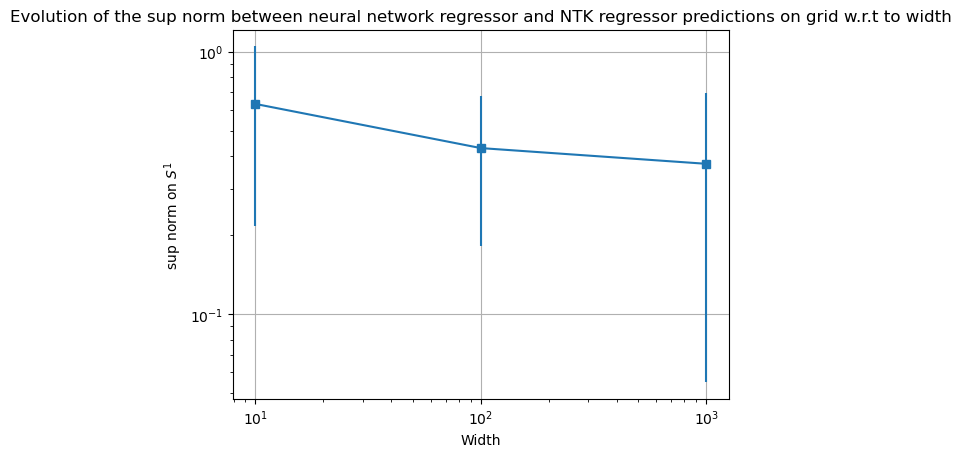

In [6]:
# Evolution of the sup norm between neural network regressor and NTK regressor w.r.t to width of the trained networks

plt.figure()
# plot mean of the network prediction minus NTK predictions ± std across seeds
plt.errorbar(xs, linf_krr_m, yerr=linf_krr_s, marker='s')  
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Width')
plt.ylabel(r'sup norm on $S^1$')
plt.title('Evolution of the sup norm between neural network regressor and NTK regressor predictions on grid w.r.t to width')
plt.grid(True)
plt.show()

# Comment: Either does not decay or decay very slowly 

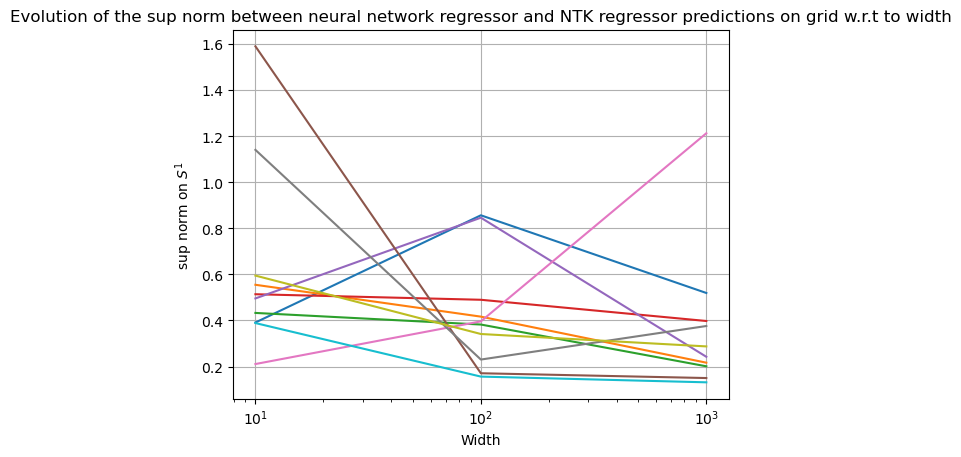

In [7]:
# Same plot as in the previous cellula, but instead of mean ± std, we plot all the seeds of sup norm between neural network regressor and NTK regressor w.r.t to width of the trained networks

linf_krr_array = np.array([v for k, v in linf_krr.items()])

plt.figure()
plt.plot(xs, linf_krr_array)
plt.xscale('log')
plt.xlabel('Width')
plt.ylabel(r'sup norm on $S^1$')
plt.title('Evolution of the sup norm between neural network regressor and NTK regressor predictions on grid w.r.t to width')
plt.grid(True)

# Comment: We see that some runs do not even decay

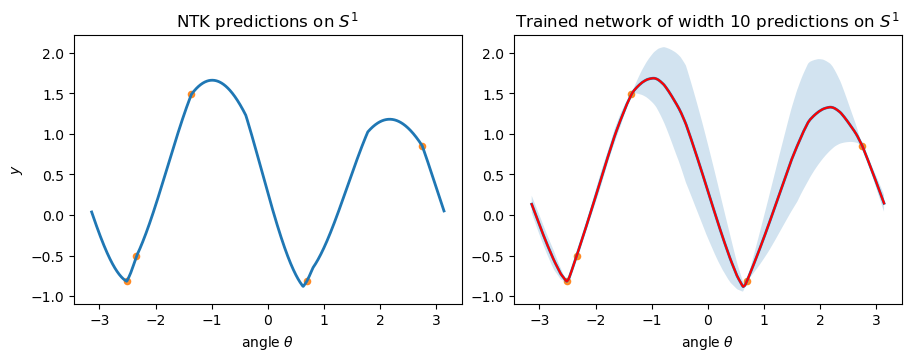

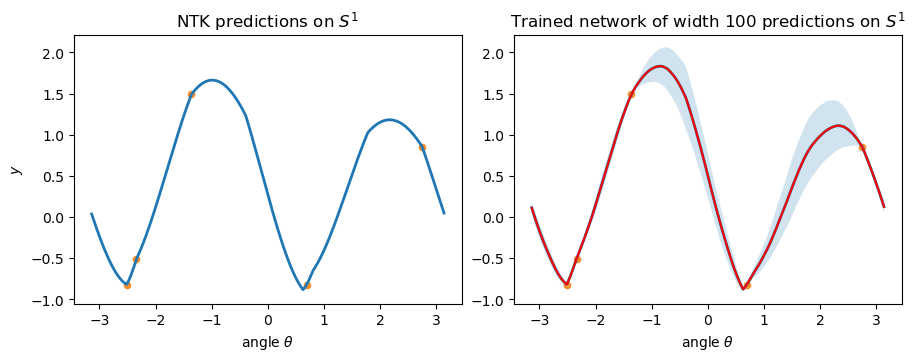

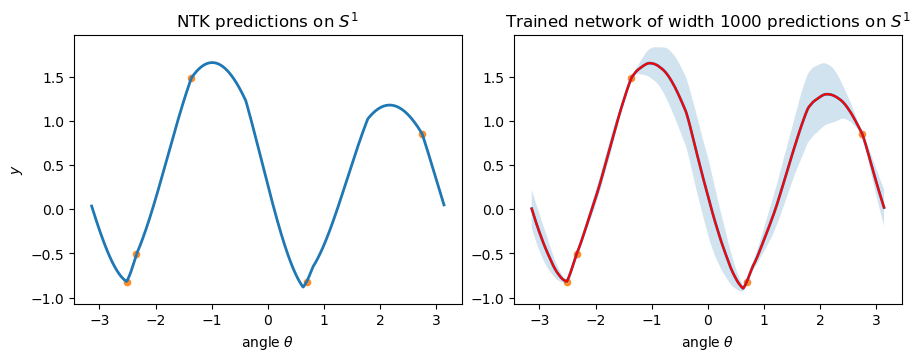

In [ ]:
# plot learned representation by network vs ntk on grid S^1 with ±std for network predictions across seeds.
# two-panel plot: NTK vs trained net along angle θ; includes ±std for network predictions 
for i in range(len(WIDTHS)):  # loop over widths
  _ = plot_ntk_vs_net_by_angle(
      Xte=Xgrid, Xtr=Xtr, ytr=ytr,
      y_ntk_test_dict=y_ntk_grid_dict,
      y_net_test_dict=y_net_grid_dict,
      width=WIDTHS[i],
      aggregate="mean",  # average across seeds
      show_std_band=True    # set True if you run multiple seeds and want ±std
  )
  plt.show()

  # Comment seed = 8 seems to give similar representation between NTK and trained networks. For seed = 2 seems noticeably different.